#conda install -c intel modin-all

In [1]:
# ****** Do not change the code in this cell! It verifies that the notebook is being run correctly! ******

def verify_and_print_times(pandas_time, modin_time):
    if modin_time < pandas_time:
        print(f"Modin was {pandas_time / modin_time:.2f}X faster than stock pandas!")
        return
    print(
        f"Oops, stock pandas appears to be {modin_time / pandas_time:.2f}X faster than Modin in this case. "
        "This is unlikely but could happen sometimes on certain machines/environments/datasets. "
        "One of the most probable reasons is the excessive amount of partitions being assigned to a single worker. "
        "You may visit Modin's optimization guide in order to learn more about such cases and how to fix them: "
        "\nhttps://modin.readthedocs.io/en/latest/usage_guide/optimization_notes/index.html\n\n"
        "But first, verify that you're using the latest Modin version, also, try to use different executions, "
        "for basic usage we recommend non-experimental 'PandasOnRay'.\n"
        "Current configuration is:"
    )
    try:
        from modin.utils import get_current_execution

        execution = get_current_execution()
    except ImportError:
        # for modin version < 0.12.0
        try:
            from modin.utils import get_current_backend

            execution = get_current_backend()
        except ImportError:
            # for modin versions < 0.8.1
            execution = (
                "Can't deduce the current execution, your Modin version is too old!"
            )
    print(f"\tExecution: {execution}")
    try:
        import modin.config as cfg

        print(
            f"\tIs experimental: {cfg.IsExperimental.get()}\n"
            f"\tNumber of CPUs to utilize by Modin (check that Modin uses all CPUs on your machine): {cfg.CpuCount.get()}\n"
            f"\tIs in debug mode (debug mode may perform slower): {cfg.IsDebug.get()}"
        )
    except (ImportError, AttributeError):
        # for modin versions < 0.8.2
        print("\tCan't deduce Modin configuration, your Modin version is too old!")
    import modin

    print(f"\tModin version: {modin.__version__}")

In [2]:
import pandas
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
import ray
ray.shutdown()
ray.init(_memory=16000 * 1024 * 1024, object_store_memory=500 * 1024 * 1024,_driver_object_store_memory=500 * 1024 * 1024)

2023-04-14 21:22:42,538	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
2023-04-14 21:22:47,037	WARNING worker.py:2093 -- `driver_object_store_memory` is deprecated and will be removed in the future.


Python version:,3.8.16
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8266


(raylet) c:\Users\vivek.p\Anaconda\envs\intel_RD\lib\site-packages\ray\dashboard\modules\reporter\reporter_agent.py:56: UserWarning: `gpustat` package is not installed. GPU monitoring is not available. To have full functionality of the dashboard please install `pip install ray[default]`.)
(raylet)   warnings.warn(


In [8]:
array=np.random.randint(low=100,high=10000,size=(2**18,2**8))
#array
np.savetxt("foo.csv", array, delimiter=",") #how to generate array

In [5]:
%%time
pandas_df = pandas.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
pandas_df.head()

CPU times: total: 7.7 s
Wall time: 7.74 s


,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col246,col247,col248,col249,col250,col251,col252,col253,col254,col255
0,6081.0,4911.0,3939.0,1567.0,5386.0,9145.0,4076.0,440.0,5596.0,4700.0,...,4909.0,7371.0,6687.0,2132.0,5409.0,4678.0,8848.0,7402.0,6513.0,2894.0
1,3413.0,7424.0,5763.0,4953.0,3339.0,6825.0,5845.0,1773.0,7172.0,9301.0,...,8942.0,3068.0,1475.0,888.0,1121.0,3912.0,3994.0,1071.0,683.0,4338.0
2,4261.0,2937.0,1610.0,345.0,6188.0,9929.0,5269.0,1143.0,5823.0,7549.0,...,6214.0,5353.0,5323.0,7537.0,2401.0,9233.0,4903.0,5197.0,1074.0,8886.0
3,753.0,4669.0,3725.0,2213.0,3404.0,834.0,3943.0,6184.0,9469.0,3527.0,...,1705.0,2304.0,2189.0,2863.0,2403.0,3890.0,1249.0,6983.0,5398.0,5318.0
4,5435.0,2539.0,8537.0,5784.0,343.0,9486.0,5800.0,9768.0,1074.0,4297.0,...,1049.0,6678.0,3538.0,6446.0,5246.0,488.0,9350.0,8270.0,1772.0,8731.0


In [6]:
%%time
modin_df=pd.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
modin_df.head(),modin_df.shape

CPU times: total: 1.56 s
Wall time: 9.16 s


(     col0    col1    col2    col3    col4    col5    col6    col7    col8  \
 0  6081.0  4911.0  3939.0  1567.0  5386.0  9145.0  4076.0   440.0  5596.0   
 1  3413.0  7424.0  5763.0  4953.0  3339.0  6825.0  5845.0  1773.0  7172.0   
 2  4261.0  2937.0  1610.0   345.0  6188.0  9929.0  5269.0  1143.0  5823.0   
 3   753.0  4669.0  3725.0  2213.0  3404.0   834.0  3943.0  6184.0  9469.0   
 4  5435.0  2539.0  8537.0  5784.0   343.0  9486.0  5800.0  9768.0  1074.0   
 
      col9  ...  col246  col247  col248  col249  col250  col251  col252  \
 0  4700.0  ...  4909.0  7371.0  6687.0  2132.0  5409.0  4678.0  8848.0   
 1  9301.0  ...  8942.0  3068.0  1475.0   888.0  1121.0  3912.0  3994.0   
 2  7549.0  ...  6214.0  5353.0  5323.0  7537.0  2401.0  9233.0  4903.0   
 3  3527.0  ...  1705.0  2304.0  2189.0  2863.0  2403.0  3890.0  1249.0   
 4  4297.0  ...  1049.0  6678.0  3538.0  6446.0  5246.0   488.0  9350.0   
 
    col253  col254  col255  
 0  7402.0  6513.0  2894.0  
 1  1071.0   683.0  

In [7]:
def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color='blue',width=0.4)
    plt.xlabel("Python Package")
    plt.ylabel("Runtime(seconds)")
    plt.show()

Pandas Time(seconds): 8.629676818847656 
Modin Time(seconds): 3.1394879817962646
Modin was 2.75X faster than stock pandas!


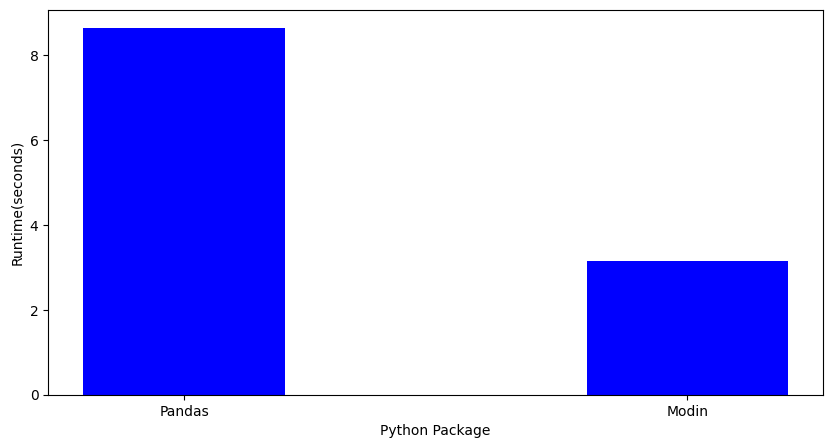

In [8]:
t0 = time.time()
pandas_df = pandas.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
pandas_time = time.time()- t0

t1 = time.time()
modin_df = pd.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
modin_time = time.time() - t1

print("Pandas Time(seconds):",pandas_time,"\nModin Time(seconds):",modin_time)
verify_and_print_times(pandas_time, modin_time)
outputDict={"Pandas":pandas_time,"Modin":modin_time}
plotter(outputDict)

In [11]:
#DataFrame Function Performance
# Long apply function
t6 = time.time()
print(pandas_df.applymap(lambda x: x + 1))
pandas_time = time.time() - t6
print(" stock Pandas wall time for completion in seconds:",pandas_time)

          col0    col1    col2    col3    col4    col5    col6    col7  \
0       6082.0  4912.0  3940.0  1568.0  5387.0  9146.0  4077.0   441.0   
1       3414.0  7425.0  5764.0  4954.0  3340.0  6826.0  5846.0  1774.0   
2       4262.0  2938.0  1611.0   346.0  6189.0  9930.0  5270.0  1144.0   
3        754.0  4670.0  3726.0  2214.0  3405.0   835.0  3944.0  6185.0   
4       5436.0  2540.0  8538.0  5785.0   344.0  9487.0  5801.0  9769.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
262139  2203.0  7402.0  3179.0  8679.0  8668.0  2678.0  4937.0  9045.0   
262140  9213.0  9434.0  8344.0  2896.0  4281.0  3337.0  3175.0  5656.0   
262141  5715.0  3010.0  9172.0  6372.0  4384.0  7378.0  2032.0  6518.0   
262142  1878.0  8875.0  5882.0  7014.0  4596.0  1400.0  3815.0  6714.0   
262143  4492.0  2197.0  2340.0   394.0  2728.0  2849.0  7809.0  4638.0   

          col8    col9  ...  col246  col247  col248  col249  col250  col251  \
0       5597.0  4701.0  ...  491

          col0    col1    col2    col3    col4    col5    col6    col7  \
0       6082.0  4912.0  3940.0  1568.0  5387.0  9146.0  4077.0   441.0   
1       3414.0  7425.0  5764.0  4954.0  3340.0  6826.0  5846.0  1774.0   
2       4262.0  2938.0  1611.0   346.0  6189.0  9930.0  5270.0  1144.0   
3        754.0  4670.0  3726.0  2214.0  3405.0   835.0  3944.0  6185.0   
4       5436.0  2540.0  8538.0  5785.0   344.0  9487.0  5801.0  9769.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
262139  2203.0  7402.0  3179.0  8679.0  8668.0  2678.0  4937.0  9045.0   
262140  9213.0  9434.0  8344.0  2896.0  4281.0  3337.0  3175.0  5656.0   
262141  5715.0  3010.0  9172.0  6372.0  4384.0  7378.0  2032.0  6518.0   
262142  1878.0  8875.0  5882.0  7014.0  4596.0  1400.0  3815.0  6714.0   
262143  4492.0  2197.0  2340.0   394.0  2728.0  2849.0  7809.0  4638.0   

          col8    col9  ...  col246  col247  col248  col249  col250  col251  \
0       5597.0  4701.0  ...  491

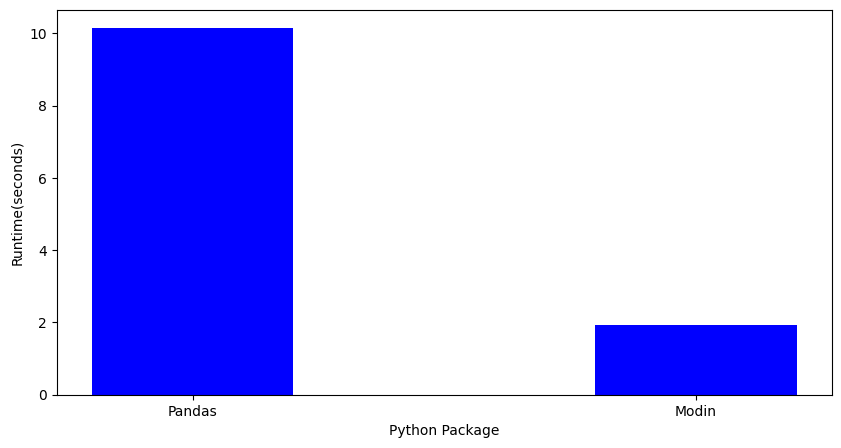

(_apply_func pid=720) 2023-04-14 21:32:38,993	ERROR import_thread.py:83 -- ImportThread: <_MultiThreadedRendezvous of RPC that terminated with:
(_apply_func pid=720) 	status = StatusCode.UNKNOWN
(_apply_func pid=720) 	details = "Stream removed"
(_apply_func pid=720) 	debug_error_string = "{"created":"@1681488159.000000000","description":"Error received from peer ipv4:127.0.0.1:65470","file":"src/core/lib/surface/call.cc","file_line":1064,"grpc_message":"Stream removed","grpc_status":2}"
(_apply_func pid=720) >
(_apply_func pid=9524) 2023-04-14 21:32:38,993	ERROR import_thread.py:83 -- ImportThread: <_MultiThreadedRendezvous of RPC that terminated with:
(_apply_func pid=9524) 	status = StatusCode.UNKNOWN
(_apply_func pid=9524) 	details = "Stream removed"
(_apply_func pid=9524) 	debug_error_string = "{"created":"@1681488159.000000000","description":"Error received from peer ipv4:127.0.0.1:65470","file":"src/core/lib/surface/call.cc","file_line":1064,"grpc_message":"Stream removed","grpc_

In [12]:
# Long apply function
t7 = time.time()
print(modin_df.applymap(lambda x: x + 1))
modin_time = time.time() - t7
print("Modin wall time for completion in seconds:",modin_time)
verify_and_print_times(pandas_time, modin_time)
outputDict={"Pandas":pandas_time,"Modin":modin_time}
plotter(outputDict)